In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [2]:
# CSVを読み込む
train= pd.read_csv("train.csv")
test= pd.read_csv("test.csv")

# データの統合
dataset = pd.concat([train, test], ignore_index = True)

# 提出用に
PassengerId = test['PassengerId']

females: 0.74
males: 0.19


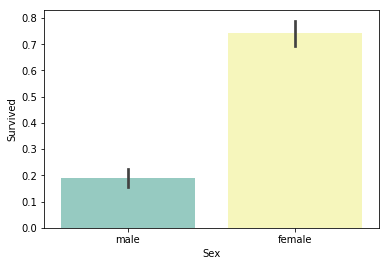

In [3]:
# 年齢と生存の帯グラフ
sns.barplot(x="Sex", y="Survived", data=train, palette='Set3')

# 性別ごとの生存率
print("females: %.2f" %(train['Survived'][train['Sex'] == 'female'].value_counts(normalize = True)[1]))
print("males: %.2f" %(train['Survived'][train['Sex'] == 'male'].value_counts(normalize = True)[1]))

Pclass = 1 : 0.63
Pclass = 2 : 0.47
Pclass = 3 : 0.24


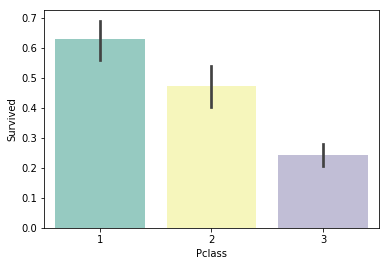

In [4]:
# チケットクラスと生存の帯グラフ
sns.barplot(x='Pclass', y='Survived', data=train, palette='Set3')

# チケットクラスごとの生存率
print("Pclass = 1 : %.2f" %(train['Survived'][train['Pclass']==1].value_counts(normalize = True)[1]))
print("Pclass = 2 : %.2f" %(train['Survived'][train['Pclass']==2].value_counts(normalize = True)[1]))
print("Pclass = 3 : %.2f" %(train['Survived'][train['Pclass']==3].value_counts(normalize = True)[1]))

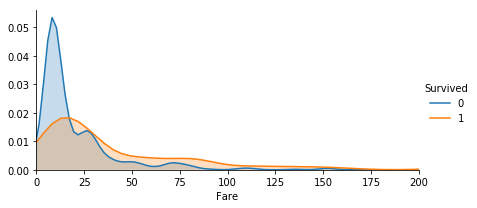

In [5]:
# 料金による生存率比較
fare = sns.FacetGrid(train, hue="Survived",aspect=2)
fare.map(sns.kdeplot,'Fare',shade= True)
fare.set(xlim=(0, 200))
fare.add_legend()

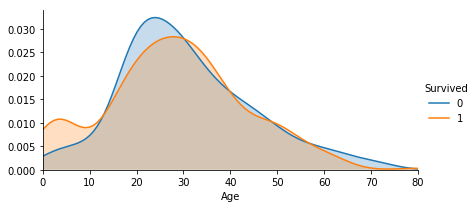

In [6]:
# 年齢による生存率比較
age = sns.FacetGrid(train, hue="Survived",aspect=2)
age.map(sns.kdeplot,'Age',shade= True)
age.set(xlim=(0, train['Age'].max()))
age.add_legend()

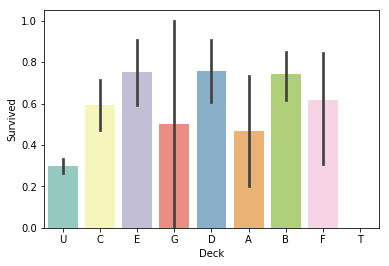

In [7]:
# 客室階層による生存率比較
dataset['Cabin'] = dataset['Cabin'].fillna('Unknown') # 客室データが欠損している場合はUnknownを代入
dataset['Deck']= dataset['Cabin'].str.get(0) #Cabin（部屋番号）の頭文字（０番目の文字）取得
sns.barplot(x="Deck", y="Survived", data=dataset, palette='Set3')

In [8]:
# Age(年齢)とFare(料金)はそれぞれの中央値、Embarked(出港地)はS(Southampton)を代入
dataset["Age"].fillna(dataset.Age.mean(), inplace=True) 
dataset["Fare"].fillna(dataset.Fare.mean(), inplace=True) 
dataset["Embarked"].fillna("S", inplace=True)

# 全体の欠損データの個数確認
dataset_null = dataset.fillna(np.nan)
dataset_null.isnull().sum()

Age              0
Cabin            0
Embarked         0
Fare             0
Name             0
Parch            0
PassengerId      0
Pclass           0
Sex              0
SibSp            0
Survived       418
Ticket           0
Deck             0
dtype: int64

In [9]:
# 使用する変数を抽出
dataset3 = dataset[['Survived','Pclass','Sex','Age','Fare','Embarked', 'Deck']]

# ダミー変数を作成
dataset_dummies = pd.get_dummies(dataset3)
dataset_dummies.head(3)

,Survived,Pclass,Age,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_U
0,0.0,3,22.0,7.2500,0,1,0,0,1,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,71.2833,1,0,1,0,0,0,0,1,0,0,0,0,0,0
2,1.0,3,26.0,7.9250,1,0,0,0,1,0,0,0,0,0,0,0,0,1


In [10]:
# データをtrainとtestに分解 
#（ 'Survived'が存在するのがtrain, しないのがtest ）
train_set = dataset_dummies[dataset_dummies['Survived'].notnull()]
test_set = dataset_dummies[dataset_dummies['Survived'].isnull()]
del test_set["Survived"]

# trainデータを変数と正解に分離
X = train_set.as_matrix()[:, 1:] # Pclass以降の変数
y = train_set.as_matrix()[:, 0] # 正解データ

# 予測モデルの作成
clf = RandomForestClassifier(random_state = 10, max_features='sqrt')
pipe = Pipeline([('classify', clf)])
param_test = {'classify__n_estimators':list(range(20, 30, 1)), #20～30を１刻みずつ試す
              'classify__max_depth':list(range(3, 10, 1))} #3～10を１刻みずつ試す
grid = GridSearchCV(estimator = pipe, param_grid = param_test, scoring='accuracy', cv=10)
grid.fit(X, y)
print(grid.best_params_, grid.best_score_, sep="\n")

# testデータの予測
pred = grid.predict(test_set)

# Kaggle提出用csvファイルの作成
submission = pd.DataFrame({"PassengerId": PassengerId, "Survived": pred.astype(np.int32)})
submission.to_csv("submission3.csv", index=False)

# train 0.8327721661054994
# test 0.78947

{'classify__max_depth': 8, 'classify__n_estimators': 22}
0.8327721661054994


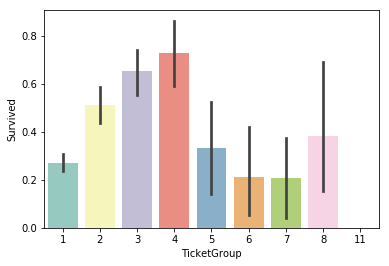

In [11]:
# チケットの文字数による生存率比較
Ticket_Count = dict(dataset['Ticket'].value_counts()) # チケットの文字数でグループ分け
dataset['TicketGroup'] = dataset['Ticket'].apply(lambda x:Ticket_Count[x]) # グループの振り分け
sns.barplot(x='TicketGroup', y='Survived', data=dataset, palette='Set3')

In [12]:
# 使用する変数を抽出
dataset4 = dataset[['Survived','Pclass','Sex','Age','Fare','Embarked', 'Deck', 'TicketGroup']]

# ダミー変数を作成
dataset_dummies = pd.get_dummies(dataset4)
dataset_dummies.head(4)

,Survived,Pclass,Age,Fare,TicketGroup,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_U
0,0.0,3,22.0,7.2500,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,71.2833,2,1,0,1,0,0,0,0,1,0,0,0,0,0,0
2,1.0,3,26.0,7.9250,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1
3,1.0,1,35.0,53.1000,2,1,0,0,0,1,0,0,1,0,0,0,0,0,0


In [14]:
# データをtrainとtestに分解 
#（ 'Survived'が存在するのがtrain, しないのがtest ）
train_set = dataset_dummies[dataset_dummies['Survived'].notnull()]
test_set = dataset_dummies[dataset_dummies['Survived'].isnull()]
del test_set["Survived"]

# trainデータを変数と正解に分離
X = train_set.as_matrix()[:, 1:] # Pclass以降の変数
y = train_set.as_matrix()[:, 0] # 正解データ

# 予測モデルの作成
clf = RandomForestClassifier(random_state = 10, max_features='sqrt')
pipe = Pipeline([('classify', clf)])
param_test = {'classify__n_estimators':list(range(20, 30, 1)), #20～30を１刻みずつ試す
              'classify__max_depth':list(range(3, 10, 1))} #3～10を１刻みずつ試す
grid = GridSearchCV(estimator = pipe, param_grid = param_test, scoring='accuracy', cv=10)
grid.fit(X, y)
print(grid.best_params_, grid.best_score_, sep="\n")

# testデータの予測
pred = grid.predict(test_set)

# Kaggle提出用csvファイルの作成
submission = pd.DataFrame({"PassengerId": PassengerId, "Survived": pred.astype(np.int32)})
submission.to_csv("submission4.csv", index=False)

# train  0.8406285072951739
# test 0.77990

{'classify__max_depth': 8, 'classify__n_estimators': 23}
0.8406285072951739


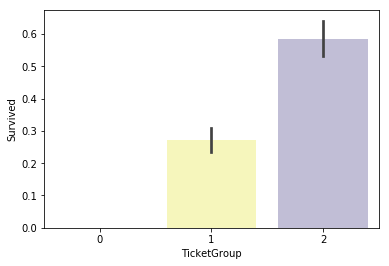

In [15]:
# チケットの文字数での生存率が高いグループと低いグループの２つに分ける。
# 高ければ２，低ければ１を代入
def Ticket_Label(s):
    if (s >= 2) & (s <= 4): # 文字数での生存率が高いグループ
        return 2
    elif ((s > 4) & (s <= 8)) | (s == 1): # 文字数での生存率が低いグループ
        return 1
    elif (s > 8):
        return 0

dataset['TicketGroup'] = dataset['TicketGroup'].apply(Ticket_Label)
sns.barplot(x='TicketGroup', y='Survived', data=dataset, palette='Set3')

In [16]:
# 使用する変数を抽出
dataset5 = dataset[['Survived','Pclass','Sex','Age','Fare','Embarked', 'Deck', 'TicketGroup']]

# ダミー変数を作成
dataset_dummies = pd.get_dummies(dataset5)
dataset_dummies.head(3)

,Survived,Pclass,Age,Fare,TicketGroup,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_U
0,0.0,3,22.0,7.2500,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,71.2833,2,1,0,1,0,0,0,0,1,0,0,0,0,0,0
2,1.0,3,26.0,7.9250,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1


In [17]:
# データをtrainとtestに分解 
#（ 'Survived'が存在するのがtrain, しないのがtest ）
train_set = dataset_dummies[dataset_dummies['Survived'].notnull()]
test_set = dataset_dummies[dataset_dummies['Survived'].isnull()]
del test_set["Survived"]

# trainデータを変数と正解に分離
X = train_set.as_matrix()[:, 1:] # Pclass以降の変数
y = train_set.as_matrix()[:, 0] # 正解データ

# 予測モデルの作成
clf = RandomForestClassifier(random_state = 10, max_features='sqrt')
pipe = Pipeline([('classify', clf)])
param_test = {'classify__n_estimators':list(range(20, 30, 1)), #20～30を１刻みずつ試す
              'classify__max_depth':list(range(3, 10, 1))} #3～10を１刻みずつ試す
grid = GridSearchCV(estimator = pipe, param_grid = param_test, scoring='accuracy', cv=10)
grid.fit(X, y)
print(grid.best_params_, grid.best_score_, sep="\n")

# testデータの予測
pred = grid.predict(test_set)

# Kaggle提出用csvファイルの作成
submission = pd.DataFrame({"PassengerId": PassengerId, "Survived": pred.astype(np.int32)})
submission.to_csv("submission5.csv", index=False)

# train 0.8417508417508418
# test 0.81339

{'classify__max_depth': 7, 'classify__n_estimators': 23}
0.8417508417508418
